# Data Leakage and How to Prevent It.

If you don't know how to prevent it, leakage will come up frequently, and it will ruin your models in subtle and dangerous ways. So, this is one of the most important concepts for practicing data scientists.



## Introduction
Data leakage (or leakage) happens when your training data contains information about the target, but similar data will not be available when the model is used for prediction. This leads to high performance on the training set (and possibly even the validation data), but the model will perform poorly in production.

In other words, leakage causes a model to look accurate until you start making decisions with the model, and then the model becomes very inaccurate.

There are two main types of leakage: target leakage and train-test contamination.



## Target leakage
Target leakage occurs when your predictors include data that will not be available at the time you make predictions. It is important to think about target leakage in terms of the timing or chronological order that data becomes available, not merely whether a feature helps make good predictions.

An example will be helpful. Imagine you want to predict who will get sick with pneumonia. The top few rows of your raw data look like this:

<font color="orange">got_pneumonia |	age	| weight | male	| took_antibiotic_medicine	...</font><br>
<font color="green">False | 	65	| 100	| False | 	False	...<br>
False	| 72	| 130	| True |	False	...<br>
True |	58	| 100	| False |	True	...

People take antibiotic medicines after getting pneumonia in order to recover. The raw data shows a strong relationship between those columns, but took_antibiotic_medicine is frequently changed after the value for got_pneumonia is determined. This is target leakage.

The model would see that anyone who has a value of False for took_antibiotic_medicine didn't have pneumonia. Since validation data comes from the same source as training data, the pattern will repeat itself in validation, and the model will have great validation (or cross-validation) scores.

But the model will be very inaccurate when subsequently deployed in the real world, because even patients who will get pneumonia won't have received antibiotics yet when we need to make predictions about their future health.

To prevent this type of data leakage, any variable updated (or created) after the target value is realized should be excluded.

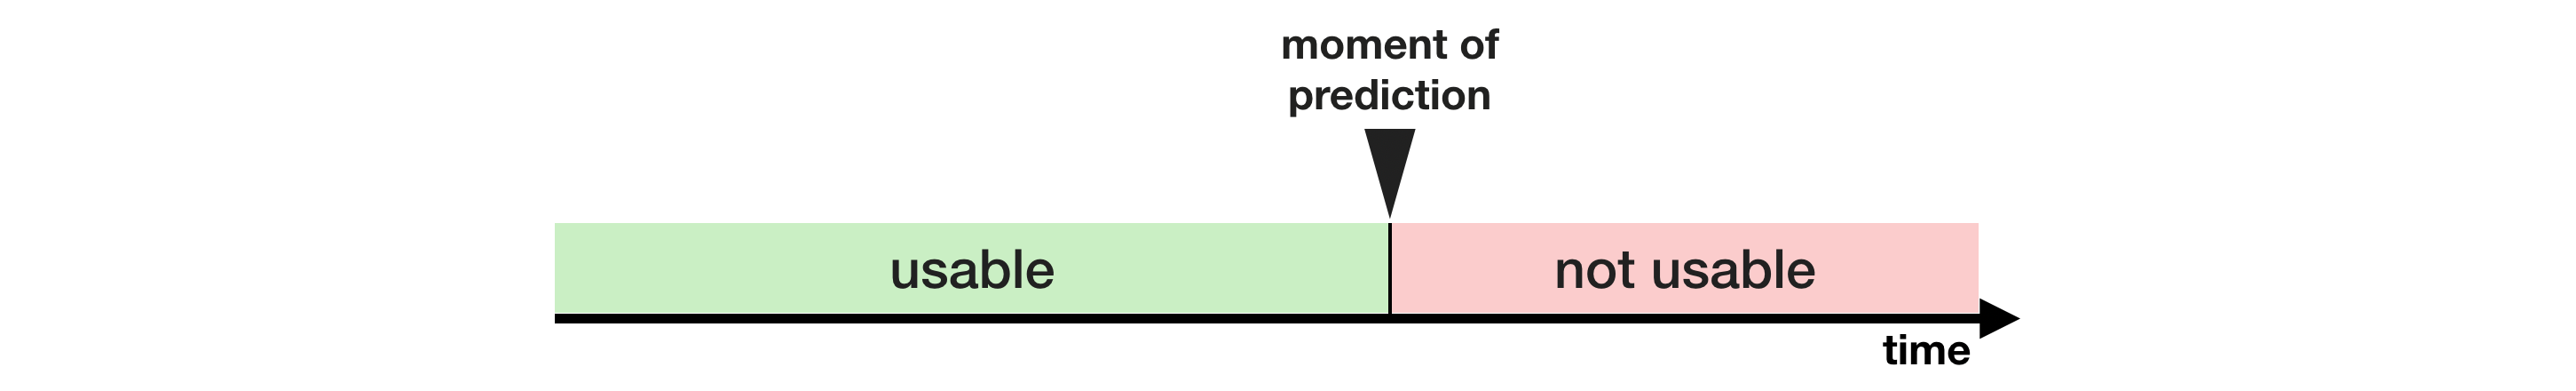

## Train-Test Contamination
A different type of leak occurs when you aren't careful to distinguish training data from validation data.

Recall that validation is meant to be a measure of how the model does on data that it hasn't considered before. You can corrupt this process in subtle ways if the validation data affects the preprocessing behavior. This is sometimes called train-test contamination.

For example, imagine you run preprocessing (like fitting an imputer for missing values) before calling train_test_split(). The end result? Your model may get good validation scores, giving you great confidence in it, but perform poorly when you deploy it to make decisions.

After all, you incorporated data from the validation or test data into how you make predictions, so the may do well on that particular data even if it can't generalize to new data. This problem becomes even more subtle (and more dangerous) when you do more complex feature engineering.

If your validation is based on a simple train-test split, exclude the validation data from any type of fitting, including the fitting of preprocessing steps. This is easier if you use scikit-learn pipelines. When using cross-validation, it's even more critical that you do your preprocessing inside the pipeline!



# Example
In this example, you will learn one way to detect and remove target leakage.

We will use a dataset about credit card applications and skip the basic data set-up code. The end result is that information about each credit card application is stored in a DataFrame X. We'll use it to predict which applications were accepted in a Series y.

In a dataset who's Number of rows in the dataset is 1319, since this is a small dataset, we will use cross-validation to ensure accurate measures of model quality.

In [1]:
import pandas as pd

# Read the data
data = pd.read_csv('/content/AER_credit_card_data.csv',
                   true_values = ['yes'], false_values = ['no'])

# Select target
y = data.card

# Select predictors
X = data.drop(['card'], axis=1)

print("Number of rows in the dataset:", X.shape[0])
X.head()

Number of rows in the dataset: 1319


,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,0,37.66667,4.5200,0.033270,124.983300,True,False,3,54,1,12
1,0,33.25000,2.4200,0.005217,9.854167,False,False,3,34,1,13
2,0,33.66667,4.5000,0.004156,15.000000,True,False,4,58,1,5
3,0,30.50000,2.5400,0.065214,137.869200,False,False,0,25,1,7
4,0,32.16667,9.7867,0.067051,546.503300,True,False,2,64,1,5


In [2]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Since there is no preprocessing, we don't need a pipeline (used anyway as best practice!)
my_pipeline = make_pipeline(RandomForestClassifier(n_estimators=100))
cv_scores = cross_val_score(my_pipeline, X, y,
                            cv=5,
                            scoring='accuracy')

print("Cross-validation accuracy: %f" % cv_scores.mean())

Cross-validation accuracy: 0.981052


With experience, you'll find that it's very rare to find models that are accurate 98% of the time. It happens, but it's uncommon enough that we should inspect the data more closely for target leakage.

Here is a summary of the data, which you can also find under the data tab:

* **card**: 1 if credit card application accepted, 0 if not
* **reports**: Number of major derogatory reports
* **age**: Age n years plus twelfths of a year
* **income**: Yearly income (divided by 10,000)
* **share**: Ratio of monthly credit card expenditure to yearly income
* **expenditure**: Average monthly credit card expenditure
* **owner**: 1 if owns home, 0 if rents
* **selfempl**: 1 if self-employed, 0 if not
* **dependents**: 1 + number of dependents
* **months**: Months living at current address
* **majorcards**: Number of major credit cards held
* **active**: Number of active credit accounts


A few variables look suspicious. For example, does expenditure mean expenditure on this card or on cards used before applying?

At this point, basic data comparisons can be very helpful:

In [3]:
expenditures_cardholders = X.expenditure[y]
expenditures_noncardholders = X.expenditure[~y]

print('Fraction of those who did not receive a card and had no expenditures: %.2f' \
      %((expenditures_noncardholders == 0).mean()))
print('Fraction of those who received a card and had no expenditures: %.2f' \
      %(( expenditures_cardholders == 0).mean()))

Fraction of those who did not receive a card and had no expenditures: 1.00
Fraction of those who received a card and had no expenditures: 0.02


As shown above, everyone who did not receive a card had no expenditures, while only 2% of those who received a card had no expenditures. It's not surprising that our model appeared to have a high accuracy. But this also seems to be a case of target leakage, where expenditures probably means expenditures on the card they applied for.

Since share is partially determined by expenditure, it should be excluded too. The variables active and majorcards are a little less clear, but from the description, they sound concerning. In most situations, it's better to be safe than sorry if you can't track down the people who created the data to find out more.

We would run a model without target leakage as follows:

In [4]:
# Drop leaky predictors from dataset
potential_leaks = ['expenditure', 'share', 'active', 'majorcards']
X2 = X.drop(potential_leaks, axis=1)

# Evaluate the model with leaky predictors removed
cv_scores = cross_val_score(my_pipeline, X2, y,
                            cv=5,
                            scoring='accuracy')

print("Cross-val accuracy: %f" % cv_scores.mean())

Cross-val accuracy: 0.833950


This accuracy is quite a bit lower, which might be disappointing. However, we can expect it to be right about 80% of the time when used on new applications, whereas the leaky model would likely do much worse than that (in spite of its higher apparent score in cross-validation).

# Conclusion
Data leakage can be multi-million dollar mistake in many data science applications. Careful separation of training and validation data can prevent train-test contamination, and pipelines can help implement this separation. Likewise, a combination of caution, common sense, and data exploration can help identify target leakage.

# Exercise

## Step 1: The Data Science of Shoelaces
Nike has hired you as a data science consultant to help them save money on shoe materials. Your first assignment is to review a model one of their employees built to predict how many shoelaces they'll need each month. The features going into the machine learning model include:

The current month (January, February, etc)
Advertising expenditures in the previous month
Various macroeconomic features (like the unemployment rate) as of the beginning of the current month
The amount of leather they ended up using in the current month
The results show the model is almost perfectly accurate if you include the feature about how much leather they used. But it is only moderately accurate if you leave that feature out. You realize this is because the amount of leather they use is a perfect indicator of how many shoes they produce, which in turn tells you how many shoelaces they need.

Do you think the leather used feature constitutes a source of data leakage? If your answer is "it depends," what does it depend on?

After you have thought about your answer, check it against the solution below.

In [5]:
# Depends on the number of shoelaces made in the current month

<font color="orange">Correct:</font>

This is tricky, and it depends on details of how data is collected (which is common when thinking about leakage). Would you at the beginning of the month decide how much leather will be used that month? If so, this is ok. But if that is determined during the month, you would not have access to it when you make the prediction. If you have a guess at the beginning of the month, and it is subsequently changed during the month, the actual amount used during the month cannot be used as a feature (because it causes leakage).

## Step 2: Return of the Shoelaces
You have a new idea. You could use the amount of leather Nike ordered (rather than the amount they actually used) leading up to a given month as a predictor in your shoelace model.

Does this change your answer about whether there is a leakage problem? If you answer "it depends," what does it depend on?

In [6]:
# This could be fine, but it depends on whether they order shoelaces first or leather first.
# If they order shoelaces first, you won't know how much leather they've ordered
# when you predict their shoelace needs. If they order leather first,
# then you'll have that number available when you place your shoelace order, and you should be ok.

## Step 3: Getting Rich With Cryptocurrencies?
You saved Nike so much money that they gave you a bonus. Congratulations.

Your friend, who is also a data scientist, says he has built a model that will let you turn your bonus into millions of dollars. Specifically, his model predicts the price of a new cryptocurrency (like Bitcoin, but a newer one) one day ahead of the moment of prediction. His plan is to purchase the cryptocurrency whenever the model says the price of the currency (in dollars) is about to go up.

The most important features in his model are:

* Current price of the currency
* Amount of the currency sold in the last 24 hours
* Change in the currency price in the last 24 hours
* Change in the currency price in the last 1 hour
* Number of new tweets in the last 24 hours that mention the currency
The value of the cryptocurrency in dollars has fluctuated up and down by over  $
 100 in the last year, and yet his model's average error is less than  $
 1. He says this is proof his model is accurate, and you should invest with him, buying the currency whenever the model says it is about to go up.

Is he right? If there is a problem with his model, what is it?

In [7]:
# There is no source of leakage here. These features should be available at the moment you want to make a
# predition, and they're unlikely to be changed in the training data after the
# prediction target is determined. But, the way he describes accuracy could be misleading
# if you aren't careful. If the price moves gradually, today's price will be an accurate
# predictor of tomorrow's price, but it may not tell you whether it's a good time to invest.
# For instance, if it is 100𝑡𝑜𝑑𝑎𝑦,𝑎𝑚𝑜𝑑𝑒𝑙𝑝𝑟𝑒𝑑𝑖𝑐𝑡𝑖𝑛𝑔𝑎𝑝𝑟𝑖𝑐𝑒𝑜𝑓 100 tomorrow may seem accurate,
# even if it can't tell you whether the price is going up or down from the current price.
#  A better prediction target would be the change in price over the next day. If you can consistently
#  predict whether the price is about to go up or down (and by how much),
# you may have a winning investment opportunity.

## Step 4: Preventing Infections
An agency that provides healthcare wants to predict which patients from a rare surgery are at risk of infection, so it can alert the nurses to be especially careful when following up with those patients.

You want to build a model. Each row in the modeling dataset will be a single patient who received the surgery, and the prediction target will be whether they got an infection.

Some surgeons may do the procedure in a manner that raises or lowers the risk of infection. But how can you best incorporate the surgeon information into the model?

You have a clever idea.

Take all surgeries by each surgeon and calculate the infection rate among those surgeons.
For each patient in the data, find out who the surgeon was and plug in that surgeon's average infection rate as a feature.
Does this pose any target leakage issues? Does it pose any train-test contamination issues?

In [8]:
# This poses a risk of both target leakage and train-test contamination
#  (though you may be able to avoid both if you are careful)

<font color="orange">Correct:</font>


You have target leakage if a given patient's outcome contributes to the infection rate for his surgeon, which is then plugged back into the prediction model for whether that patient becomes infected. You can avoid target leakage if you calculate the surgeon's infection rate by using only the surgeries before the patient we are predicting for. Calculating this for each surgery in your training data may be a little tricky.

You also have a train-test contamination problem if you calculate this using all surgeries a surgeon performed, including those from the test-set. The result would be that your model could look very accurate on the test set, even if it wouldn't generalize well to new patients after the model is deployed. This would happen because the surgeon-risk feature accounts for data in the test set. Test sets exist to estimate how the model will do when seeing new data. So this contamination defeats the purpose of the test set.

## Step 5: Housing Prices
You will build a model to predict housing prices. The model will be deployed on an ongoing basis, to predict the price of a new house when a description is added to a website. Here are four features that could be used as predictors.

* Size of the house (in square meters)
* Average sales price of homes in the same neighborhood
* Latitude and longitude of the house
* Whether the house has a basement
You have historic data to train and validate the model.

Which of the features is most likely to be a source of leakage?

In [9]:
# Fill in the line below with one of 1, 2, 3 or 4.
potential_leakage_feature = 2

<font color="orange">Correct:</font>

Here is an analysis for each feature:

The size of a house is unlikely to be changed after it is sold (though technically it's possible). But typically this will be available when we need to make a prediction, and the data won't be modified after the home is sold. So it is pretty safe.

We don't know the rules for when this is updated. If the field is updated in the raw data after a home was sold, and the home's sale is used to calculate the average, this constitutes a case of target leakage. At an extreme, if only one home is sold in the neighborhood, and it is the home we are trying to predict, then the average will be exactly equal to the value we are trying to predict. In general, for neighborhoods with few sales, the model will perform very well on the training data. But when you apply the model, the home you are predicting won't have been sold yet, so this feature won't work the same as it did in the training data.

These don't change, and will be available at the time we want to make a prediction. So there's no risk of target leakage here.

This also doesn't change, and it is available at the time we want to make a prediction. So there's no risk of target leakage here.

# Conclusion
Leakage is a hard and subtle issue. You should be proud if you picked up on the issues in these examples.

Now you have the tools to make highly accurate models, and pick up on the most difficult practical problems that arise with applying these models to solve real problems.

There is still a lot of room to build knowledge and experience. Try out a Competition or look through our Datasets to practice your new skills.